In [70]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
path = "input/arima/AirPassengers.csv" #For Kaggle
dataset = pd.read_csv(path)
#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


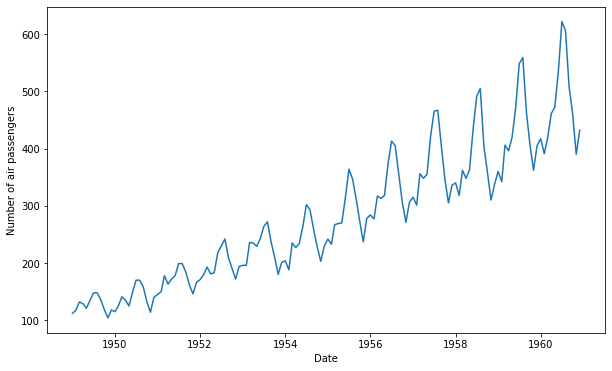

In [3]:
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

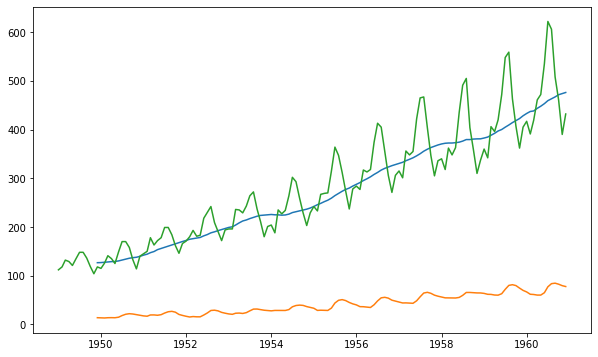

In [7]:
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()
plt.plot(rolmean)
plt.plot(rolstd)
plt.plot(indexedDataset)
plt.show()

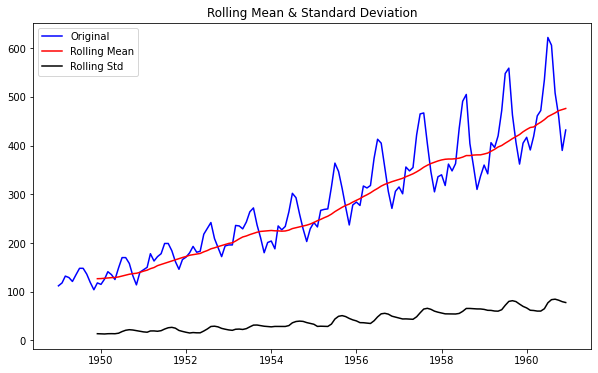

In [8]:
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [11]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


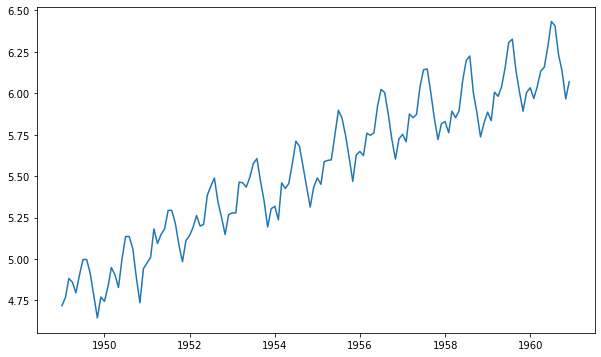

In [12]:
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

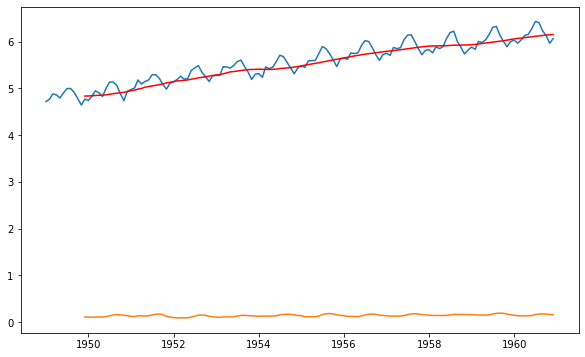

In [13]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')
plt.plot(movingSTD)

In [14]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


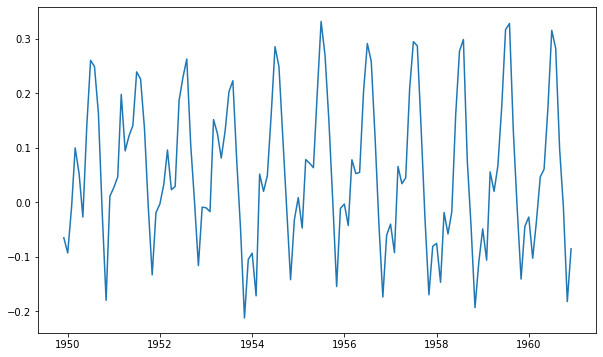

In [15]:
plt.plot(datasetLogScaleMinusMovingAverage)

In [16]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

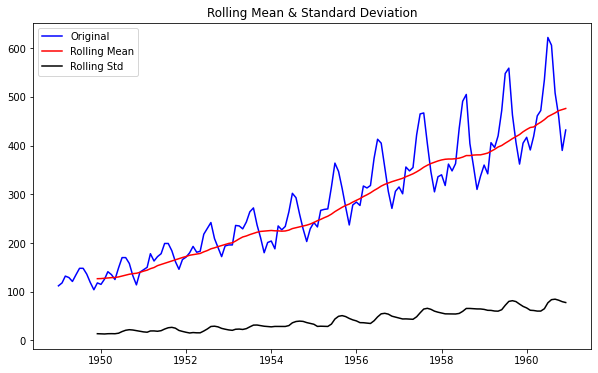

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
test_stationarity(indexedDataset)

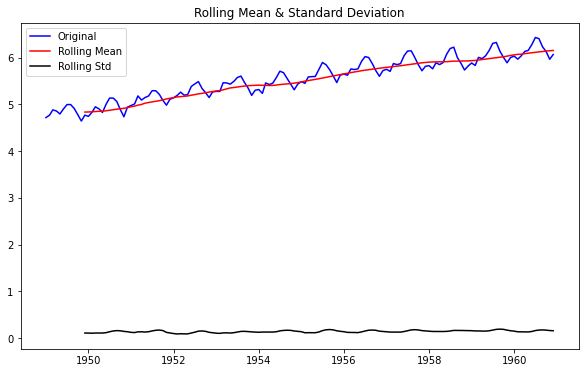

Results of Dickey Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [19]:
test_stationarity(indexedDataset_logScale)
# rolling mean

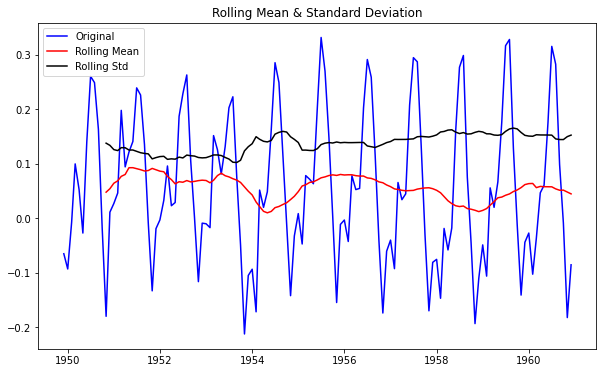

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [20]:
test_stationarity(datasetLogScaleMinusMovingAverage)

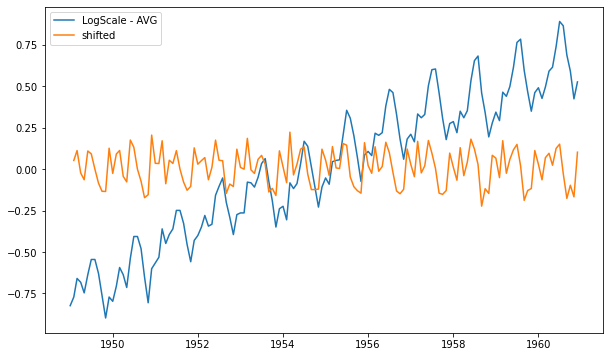

In [27]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(indexedDataset_logScale-np.mean(indexedDataset_logScale),label = 'LogScale - AVG')
plt.plot(datasetLogDiffShifting,label = 'shifted')
plt.legend()

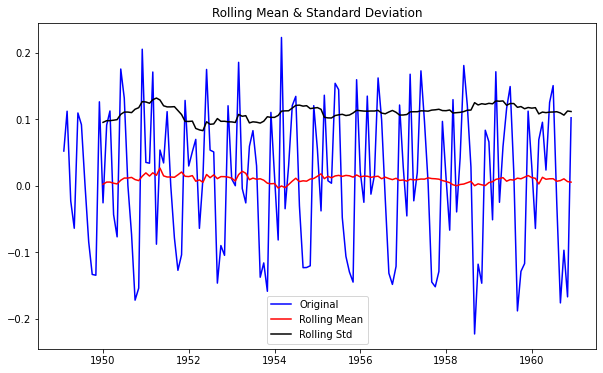

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [28]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

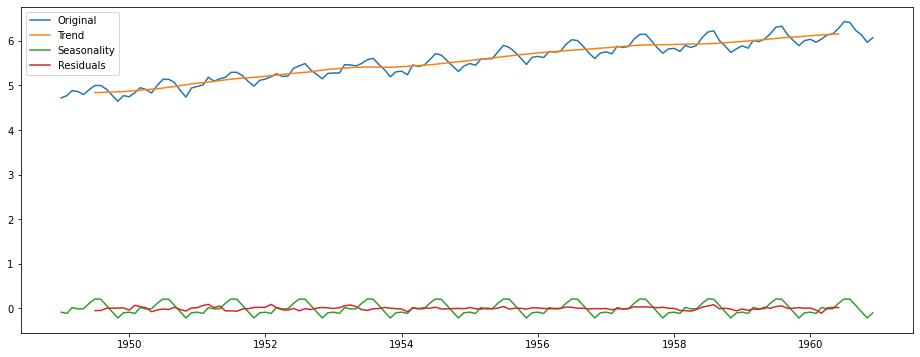

In [53]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = [16,6])
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.plot(residual, label='Residuals')
plt.legend(loc='best')


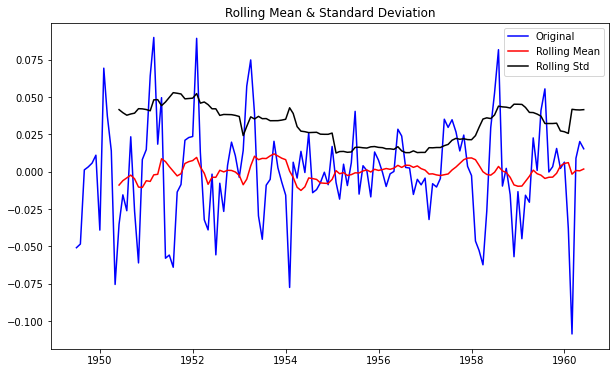

Results of Dickey Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [50]:
residual = residual.to_frame()
residual.columns = ["#Passengers"]
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

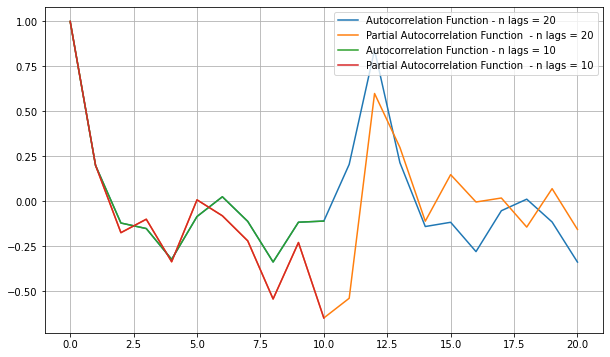

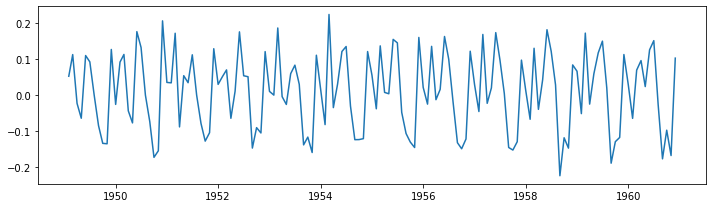

In [62]:
lag_acf = acf(datasetLogDiffShifting, nlags=20, fft = False)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')
lag_acf_10 = acf(datasetLogDiffShifting, nlags=10, fft = False)
lag_pacf_10 = pacf(datasetLogDiffShifting, nlags=10, method='ols')
plt.plot(lag_acf, label = 'Autocorrelation Function - n lags = 20')
plt.plot(lag_pacf, label = 'Partial Autocorrelation Function  - n lags = 20')
plt.plot(lag_acf_10, label = 'Autocorrelation Function - n lags = 10')
plt.plot(lag_pacf_10, label = 'Partial Autocorrelation Function  - n lags = 10')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize = [10,3])
plt.plot(datasetLogDiffShifting)
plt.tight_layout() 

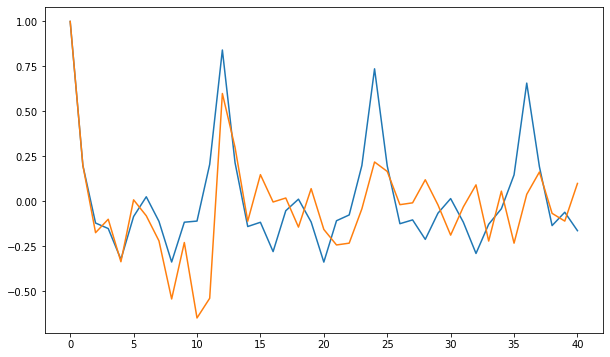

In [64]:
lag_acf = acf(datasetLogDiffShifting, nlags=40, fft = False)
lag_pacf = pacf(datasetLogDiffShifting, nlags=40, method='ols')
plt.plot(lag_acf, label = 'Autocorrelation Function - n lags = 40')
plt.plot(lag_pacf, label = 'Partial Autocorrelation Function  - n lags = 40')

Plotting AR model


c:\d\python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\d\python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


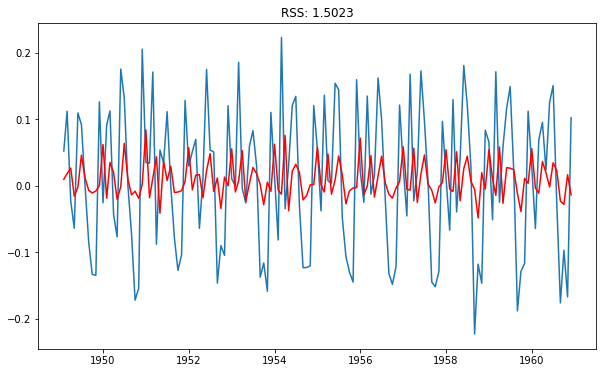

In [71]:
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting AR model')

Plotting MA model


c:\d\python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\d\python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


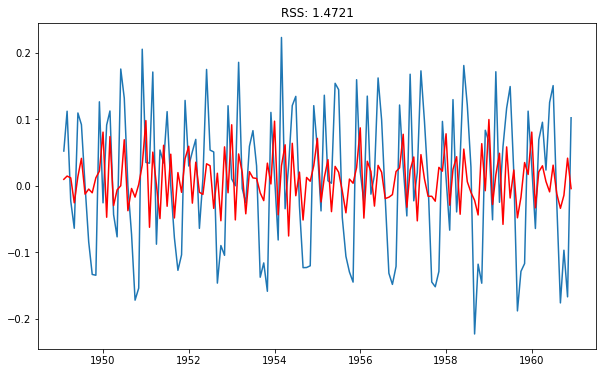

In [72]:
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting MA model')

c:\d\python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\d\python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting ARIMA model


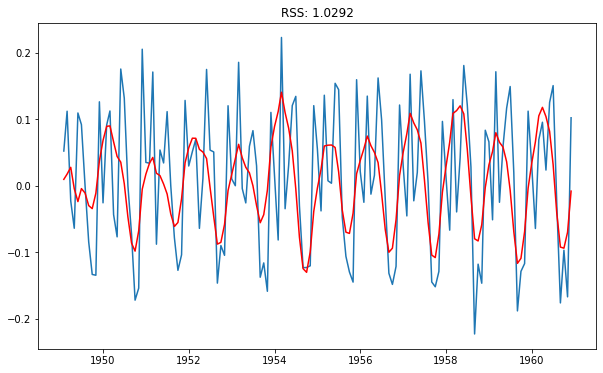

In [73]:
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

In [97]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [98]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027072
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026332
dtype: float64

In [103]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

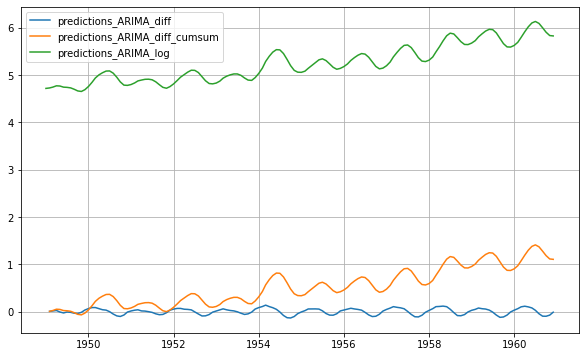

In [104]:
plt.plot(predictions_ARIMA_diff, label = 'predictions_ARIMA_diff')
plt.plot(predictions_ARIMA_diff_cumsum, label = 'predictions_ARIMA_diff_cumsum')
plt.plot(predictions_ARIMA_log, label = 'predictions_ARIMA_log')
plt.legend()
plt.grid(True)
plt.show()

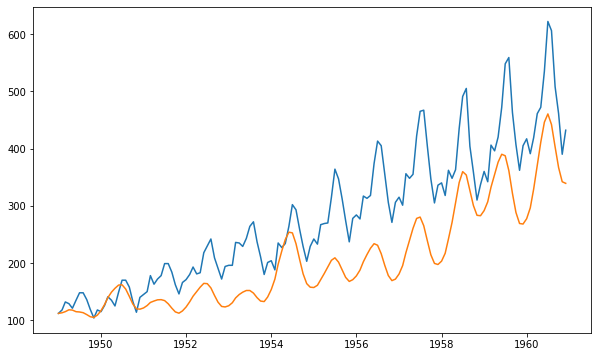

In [105]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

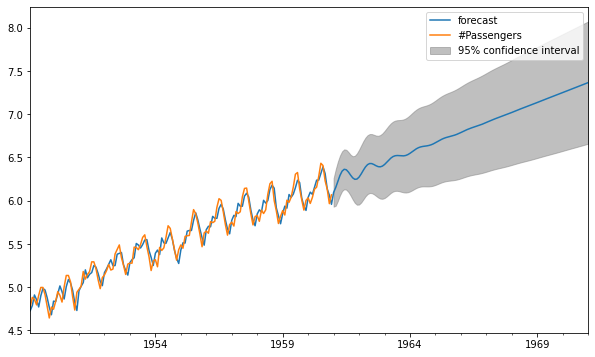

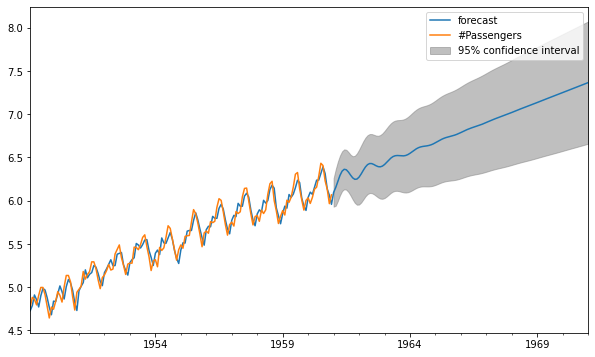

In [106]:
results_ARIMA.plot_predict(1,264)

Plotting MA model


c:\d\python\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\d\python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  wa

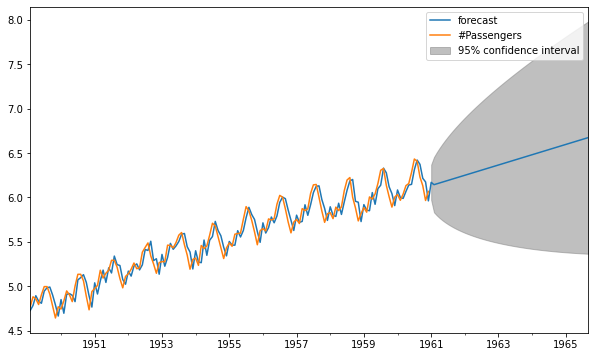

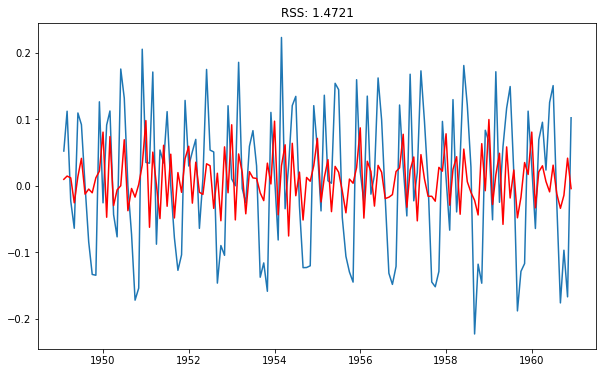

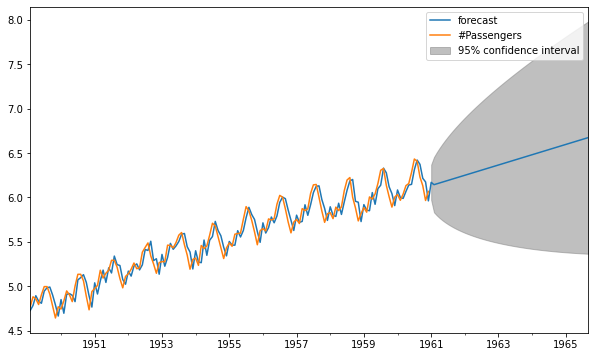

In [109]:
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting MA model')
results_MA.plot_predict(1,200)

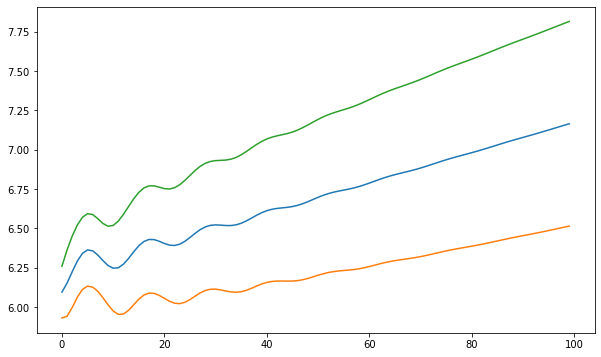

In [118]:
plt.plot(results_ARIMA.forecast(100)[0])
plt.plot(results_ARIMA.forecast(100)[2])

In [117]:
results_ARIMA.forecast(10)

(array([6.09553363, 6.15281356, 6.22442919, 6.29241072, 6.34164714,
        6.36359389, 6.35784734, 6.3313936 , 6.2959759 , 6.26447747]),
 array([0.0838471 , 0.10749459, 0.1156869 , 0.11702769, 0.11703491,
        0.11744013, 0.11762245, 0.11778709, 0.12024159, 0.12736042]),
 array([[5.93119632, 6.25987093],
        [5.94212803, 6.36349909],
        [5.99768703, 6.45117135],
        [6.06304065, 6.52178078],
        [6.11226293, 6.57103136],
        [6.13341547, 6.59377231],
        [6.12731157, 6.58838311],
        [6.10053515, 6.56225205],
        [6.06030671, 6.53164509],
        [6.01485563, 6.51409931]]))

In [120]:
pred_goods = pd.read_csv("input/sportisimo/pred_goods.csv")

In [121]:
pred_goods

,Unnamed: 0,SalesQty_55597,SalesQty_97397,SalesQty_92867,SalesQty_95247,SalesQty_106877,SalesQty_97094,SalesDate
0,0,25.0,51.0,19.0,3.0,5.0,3.0,2021-01-01
1,1,58.0,59.0,45.0,9.0,5.0,4.0,2021-01-02
2,2,53.0,45.0,52.0,13.0,4.0,11.0,2021-01-03
3,3,51.0,43.0,57.0,9.0,11.0,7.0,2021-01-04
4,4,42.0,49.0,54.0,9.0,4.0,4.0,2021-01-05
...,...,...,...,...,...,...,...,...
243,243,367.0,190.0,153.0,50.0,45.0,85.0,2021-09-01
244,244,323.0,147.0,147.0,84.0,49.0,114.0,2021-09-02
245,245,303.0,199.0,124.0,76.0,56.0,83.0,2021-09-03
246,246,319.0,232.0,95.0,85.0,74.0,80.0,2021-09-04


In [122]:
test

NameError: name 'test' is not defined